# 0.0 START

## 0.1 Imports

In [1]:
import math
import pandas as pd
import inflection
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## 0.2 Helper functions

## 0.3 Loading data

In [2]:

#* df = dataframe
#* raw = without any modificantion
#* read_csv is a function used with pandas library
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)

#* merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

## 0.4 Colors

In [3]:
red = '#F15854'
blue = '#5DA5DA'
orange = '#FAA43A'
green = '#60BD68'
pink = '#F17CB0'
brown = '#B2912F'
purple = '#B276B2'
yellow = '#DECF3F'
gray = '#4D4D4D'

# 1.0 DATA DESCRIPTION

## 1.1 Data fields

*Id*: an Id that represents a (Store, Date) duple within the test set

*Store*: a unique Id for each store

*Sales*: the turnover for any given day (this is what you are predicting)

*Customers*: the number of customers on a given day

*Open*: an indicator for whether the store was open: 0 = closed, 1 = open

*State Holiday*: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

*School Holiday*: indicates if the (Store, Date) was affected by the closure of public schools

*Store Type*: differentiates between 4 different store models: a, b, c, d

*Assortment*: describes an assortment level: a = basic, b = extra, c = extended

*Competition Distance*: distance in meters to the nearest competitor store

*Competition Open Since Month/Year*: gives the approximate year and month of the time the nearest competitor was opened

*Promo*: indicates whether a store is running a promo on that day

*Promo 2*: Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

*Promo 2 Since Year/Week*: describes the year and calendar week when the store started participating in Promo2

*Promo Interval*: describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

## 1.2 Rename columns

In [4]:
# *Always create a copy of the df
df1 = df_raw.copy()

In [5]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
            'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']


def snakecase(x): return inflection.underscore(x)


cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

## 1.3 Data dimensions

In [6]:
print(f'Number of rows: {df1.shape[0]} \nNumber of columns: {df1.shape[1]}')

Number of rows: 1017209 
Number of columns: 18


## 1.4 Data types

In [7]:
# Changing the date type from object to datetime
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.5 Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.6 Fillout NA

In [9]:
df1['competition_distance'].max()

75860.0

In [10]:
# competition_distance
# for complete the NaN elements, just apply a lambda function with a value > df1['competition_distance'].max()
df1['competition_distance'] = df1['competition_distance'].apply(
    lambda x: 2000000.0 if math.isnan(x) else x)

# competition_open_since_month
# change the NaN elements to date
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(
    x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year
# equal to competition_since_month
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(
    x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(
    x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(
    x['promo2_since_year']) else x['promo2_since_year'], axis=1)


# promo_interval
# Changing names of month to numbers makes the manipulation easier
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',
             7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

# There's a list, use .map instead of .apply
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(
    lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 1.7 Change Types

In [11]:
#!Converting competition_open_since_month, competition_open_since_year, promo2_since_week, promo2_since_year  from float to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(
    int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(
    int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.8 Descriptive Statistical

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(
    exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.8.1 Numerical Attributes

In [13]:
# * Central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#* Dispersion - std, min, max, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T


#! Range is the difference between the max value and min value
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T

d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# * Concat
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range',
             'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,2000000.0,1999980.0,10610.588099,2330.0,101810.649100,19.378002,375.644405
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


[Text(0.5, 141.0, '')]

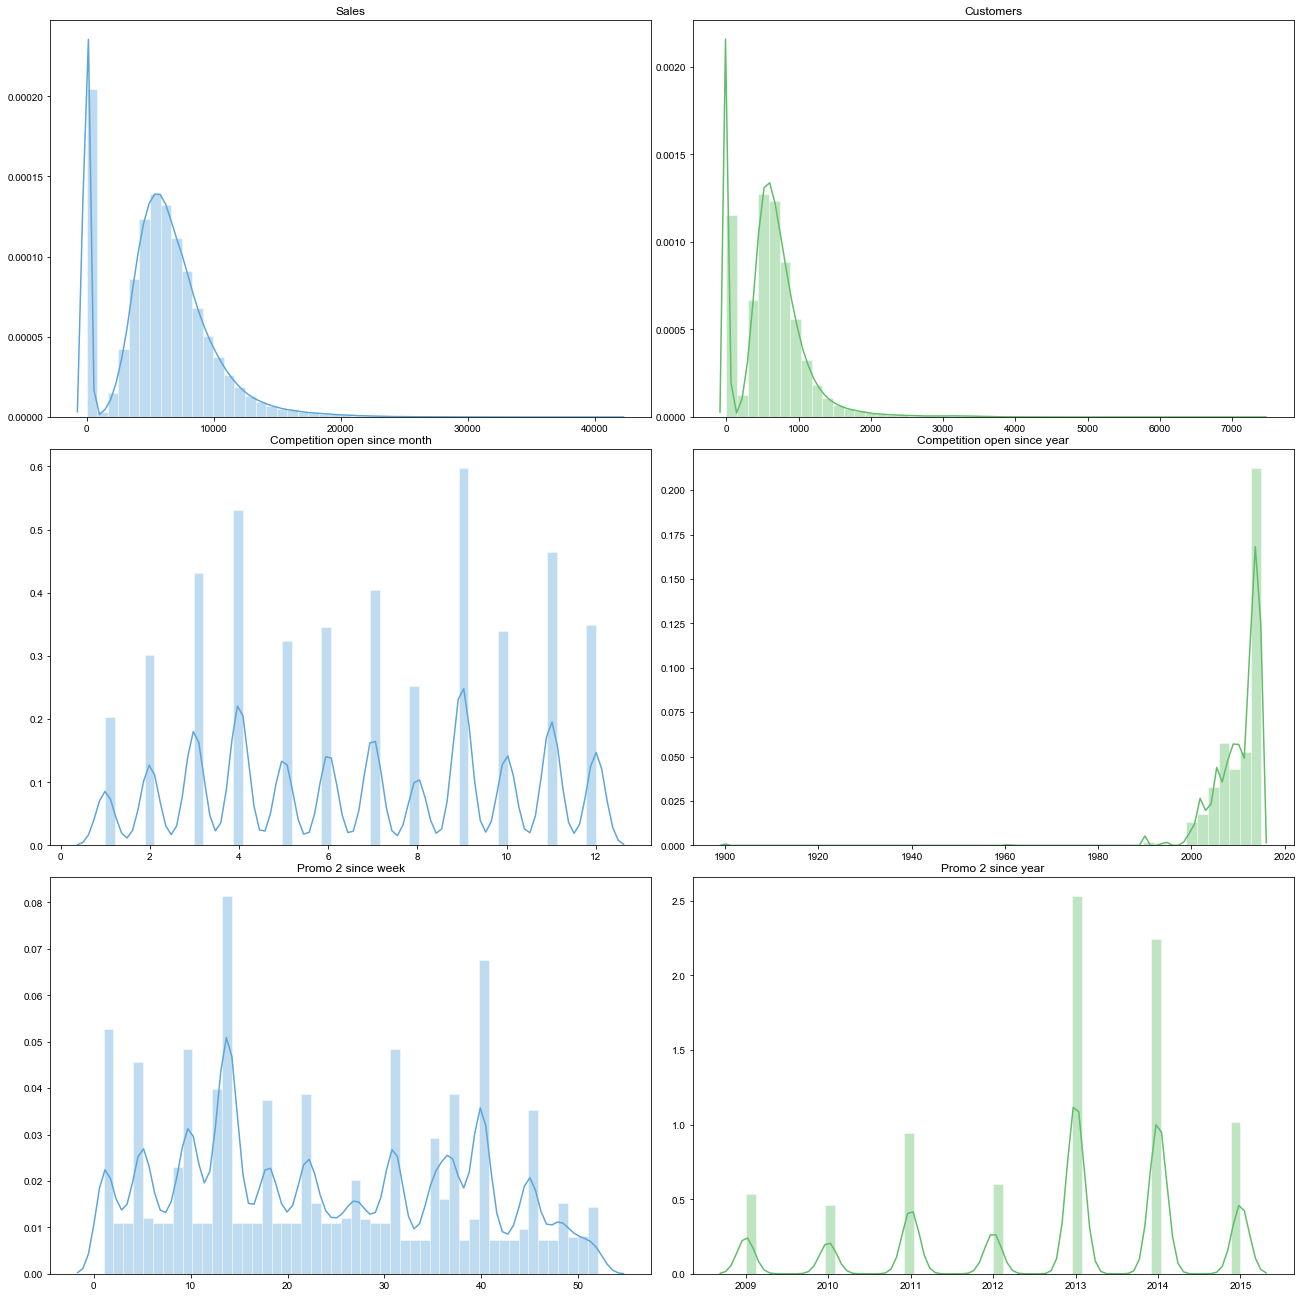

In [14]:
# Using subplot and adjusting the size of the plots
fig1, axes = plt.subplots(3, 2, figsize=(18, 18))
fig1.tight_layout()

# Sales
sns.set(style='dark')
dist_sales = sns.distplot(df1['sales'], color=blue, ax=axes[0, 0])
dist_sales.set_title('Sales')
dist_sales.set(xlabel='')

# Customers
dist_customers = sns.distplot(df1['customers'], color=green, ax=axes[0, 1])
dist_customers.set_title('Customers')
dist_customers.set(xlabel='')

# Competition Open Since Month
dist_competition_open_since_month = sns.distplot(
    df1['competition_open_since_month'], color=blue, ax=axes[1, 0])
dist_competition_open_since_month.set_title('Competition open since month')
dist_competition_open_since_month.set(xlabel='')

# Competition Open Since Year
dist_competition_open_since_year = sns.distplot(
    df1['competition_open_since_year'], color=green, ax=axes[1, 1])
dist_competition_open_since_year.set_title('Competition open since year')
dist_competition_open_since_year.set(xlabel='')

# Promo 2 Since Week
dist_promo2_since_week = sns.distplot(
    df1['promo2_since_week'], color=blue, ax=axes[2, 0])
dist_promo2_since_week.set_title('Promo 2 since week')
dist_promo2_since_week.set(xlabel='')

# Promo 2 Since Year
dist_promo2_since_year = sns.distplot(
    df1['promo2_since_year'], color=green, ax=axes[2, 1])
dist_promo2_since_year.set_title('Promo 2 since year')
dist_promo2_since_year.set(xlabel='')

### 1.8.2 Categorical attributes

In [15]:
#! List of categorical attributes
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

[Text(0, 0.5, ''), Text(0.5, 0, 'Assortment')]

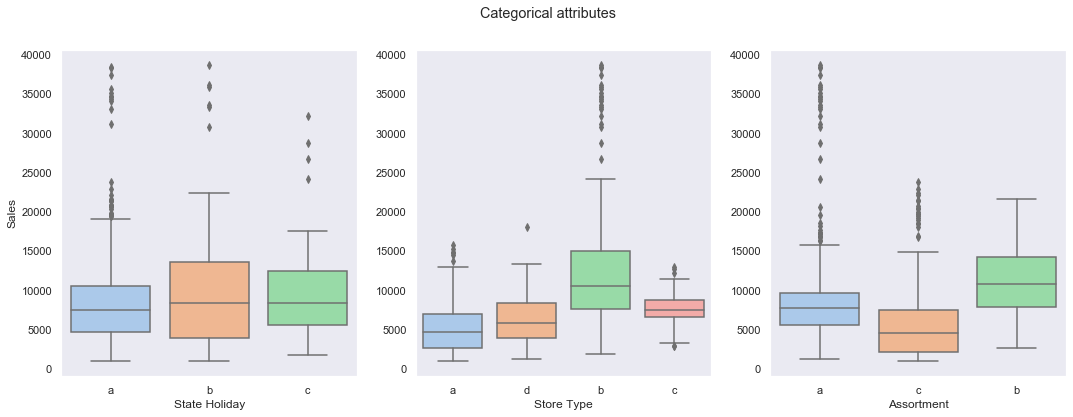

In [16]:
#! Conditions
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# Using subplot and adjusting the size of the plots
fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
fig2.suptitle('Categorical attributes')

# Boxplot 1
sns.set_style("darkgrid")
bp_state_holiday = sns.boxplot(
    ax=ax1, data=aux, x='state_holiday', y='sales', palette='pastel')
bp_state_holiday.set(xlabel="State Holiday", ylabel="Sales")

# Boxplot 2
bp_store_type = sns.boxplot(
    ax=ax2, data=aux, x='store_type', y='sales', palette='pastel')
bp_store_type.set(xlabel="Store Type", ylabel="")

# Boxplot 3
bp_assortment = sns.boxplot(
    ax=ax3, data=aux, x='assortment', y='sales', palette='pastel')
bp_assortment.set(xlabel="Assortment", ylabel="")